In [118]:
import pandas as pd
from datetime import datetime

In [119]:
directory='/home/tanmay/coding/minor project 3/dataset/monthly-sales.csv'
df=pd.read_csv(directory)
df.columns=["Months","Sales"]

In [120]:
#removing irrelvant rows
df = df.dropna()

#changing dateTime format
df['Months']=pd.to_datetime(df['Months'])



In [90]:
df.tail(20)

,Months,Sales
85,1971-02-01,3162.0
86,1971-03-01,4286.0
87,1971-04-01,4676.0
88,1971-05-01,5010.0
89,1971-06-01,4874.0
90,1971-07-01,4633.0
91,1971-08-01,1659.0
92,1971-09-01,5951.0
93,1971-10-01,6981.0
94,1971-11-01,9851.0


In [91]:
df.set_index("Months", inplace=True)
df

,Sales
Months,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


<AxesSubplot: xlabel='Months'>

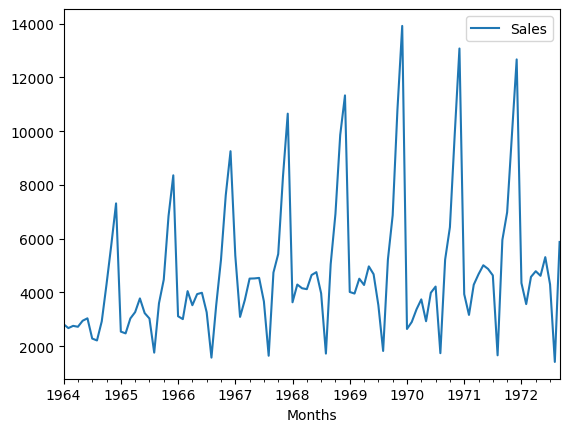

In [92]:
df.plot()

In [93]:
from statsmodels.tsa.stattools import adfuller

In [94]:
res=adfuller(df['Sales'])
res
#if p-value(2nd row of outpt)<=0.05 then stationary else not-stationary
#here p-value=0.36391577166024586, therefore not-stationary
#its also visible from the plot above

(-1.8335930563276215,
 0.36391577166024586,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

So how to make it stationary:

1. Differecing

In [95]:
# df['Sales'].shift(1)  #this will shift one value down

df['Sales 1st diff']=df['Sales']-df['Sales'].shift(1)

#but as seen from the plot the data is seasonal, so instead of shifting it just once will we shift it by one year
#that is 12 months threfore:
df['Seasonal diff']=df['Sales']-df['Sales'].shift(12)

In [96]:
df.head(15) #here we can see that the Seasonal diff is calculated by shifting 12 months

,Sales,Sales 1st diff,Seasonal diff
Months,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [97]:
#so now again running the stationary test on the seasonal differenced data
res=adfuller(df['Seasonal diff'].dropna()) #dropna is used to exclude the rows with NaN values
res
#so here the p-val=2.0605796968136632e-11 which is <0.05 therefore its stationary

(-7.626619157213166,
 2.0605796968136632e-11,
 0,
 92,
 {'1%': -3.503514579651927,
  '5%': -2.893507960466837,
  '10%': -2.583823615311909},
 1294.7753384560438)

<AxesSubplot: xlabel='Months'>

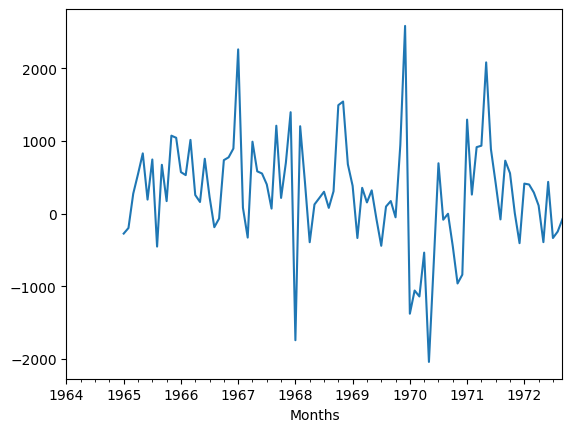

In [98]:
df['Seasonal diff'].plot()
#this also looks stationary

Now we will do auto correlation: it is used to determine that how much lag we will have to use to do the predictoins successfully
ie. how much prev data will be required to make successful predictions

in ARIMA model there are 3 values:
1.  p:AR model lags
2.  d: differencing
3.  q: MA model lags 

I in ARIMA stands for differencing, so if we don't difference the model then its simply ARMA model
AR is often done best with PACF(partial auto correlation function)

In [99]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm

Now to know how many lags should we consider, we use pacf:
1. the below graph has pacf as y axis and lags as x axis

/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


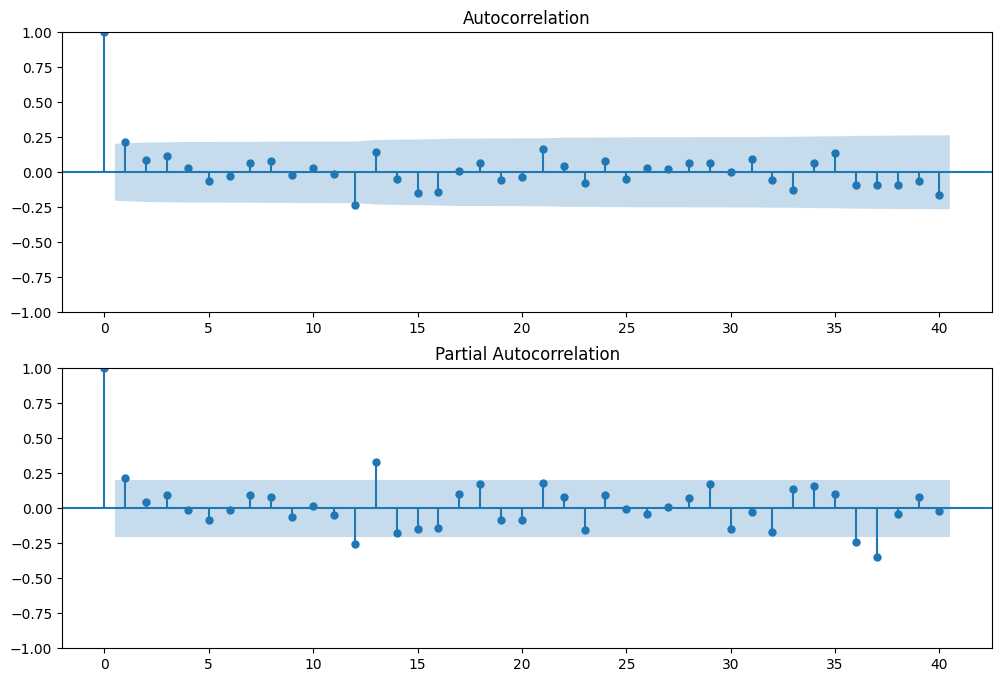

In [100]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_acf(df['Seasonal diff'].dropna(),lags=40,ax=ax1)
fig=sm.graphics.tsa.plot_pacf(df['Seasonal diff'].dropna(),lags=40,ax=ax2)

the blue area is the significance line, so the lags above the sgnificance lines tells the value of p or q depending on the graph:
1. the pacf graph will tell p value (here its 1)
1. the acf graph will tell q value (here its 1 or we can take 0 also)

In [101]:
from statsmodels.tsa.arima.model import ARIMA
# import statsmodels.tsa.arima.model


In [102]:
model = ARIMA(df['Sales'], order=(1,1,1)) #p=1, q=1, d=1
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Mon, 28 Nov 2022   AIC                           1911.627
Time:                        01:08:00   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      4.001      0.000       0.232       0.677
ma.L1         -0.9667      0.056    -17.329      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.472      0.0

/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='Months'>

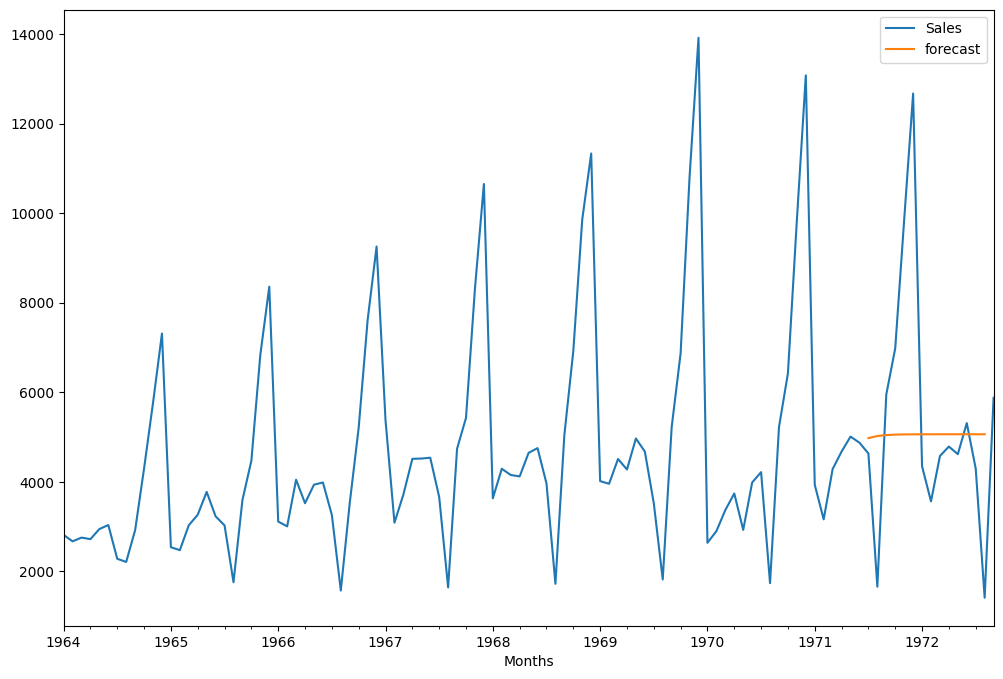

In [103]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

since the normal arima is doing very poor predictions, we need to do SARIMA for seasonal data

In [104]:

model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()


/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07295D+00    |proj g|=  4.80911D-02

At iterate    5    f=  7.04942D+00    |proj g|=  1.53381D-02

At iterate   10    f=  7.04713D+00    |proj g|=  2.99454D-04

At iterate   15    f=  7.04708D+00    |proj g|=  5.05921D-03

At iterate   20    f=  7.04413D+00    |proj g|=  1.18441D-02

At iterate   25    f=  7.03252D+00    |proj g|=  1.05955D-03

At iterate   30    f=  7.03240D+00    |proj g|=  6.01298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<AxesSubplot: xlabel='Months'>

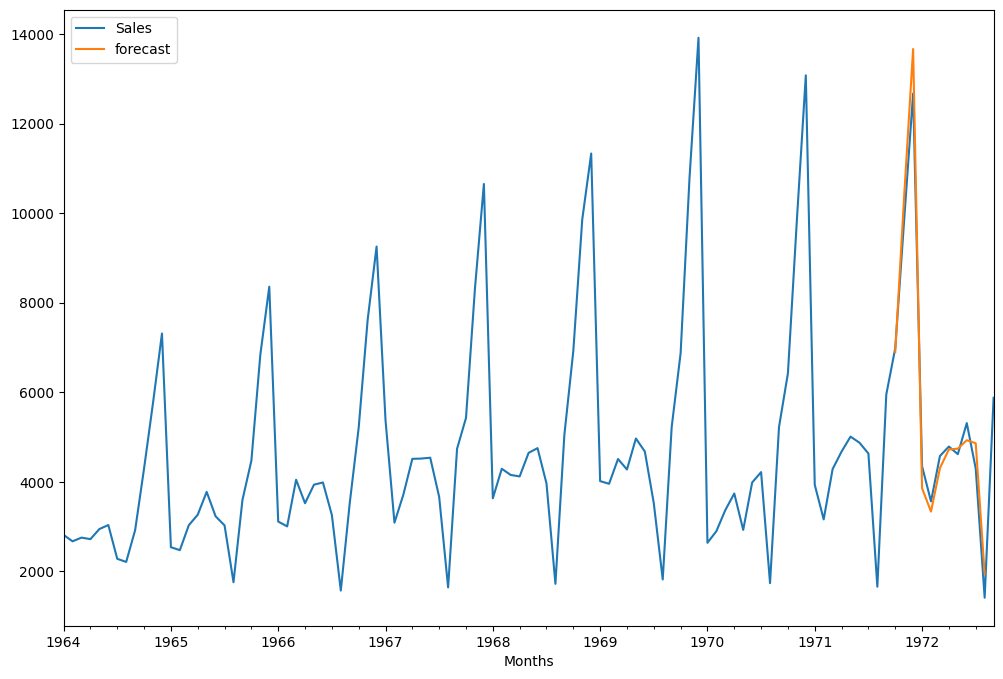

In [105]:
#here start is the starting index from where we want to start the prediction from
df['forecast']=results.predict(start=93,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

Accuracy check:

In [106]:
tst=df['Sales'].iloc[93:104]
pred=df['forecast'].dropna()

In [107]:
pred.dropna()

Months
1971-10-01     6895.883854
1971-11-01    10383.603426
1971-12-01    13664.208772
1972-01-01     3858.033953
1972-02-01     3336.268316
1972-03-01     4308.117496
1972-04-01     4723.586144
1972-05-01     4739.963897
1972-06-01     4928.844779
1972-07-01     4862.576271
1972-08-01     1945.125568
Name: forecast, dtype: float64

In [108]:
import numpy as np

In [109]:
#MAPE (Mean absolute percentage error)
mape = np.mean((pred - tst)/(tst))
mape


0.030344443822934265

since the error is 3% so accuracy is 97%

_____________________________________________________________________________________________________________________

Now doing Predictions

so now to do future pridiction we need to extend the df to few dates ahead with null values which then will be filled with the predicted values

In [110]:
from pandas.tseries.offsets import DateOffset
#creating extra indexes
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]



In [111]:
#creating df using the extra indexes
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df


,Sales,Sales 1st diff,Seasonal diff,forecast
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN,NaN


In [112]:
# now concatinating that extra df with the original df
future_df=pd.concat([df,future_datest_df])

<AxesSubplot: >

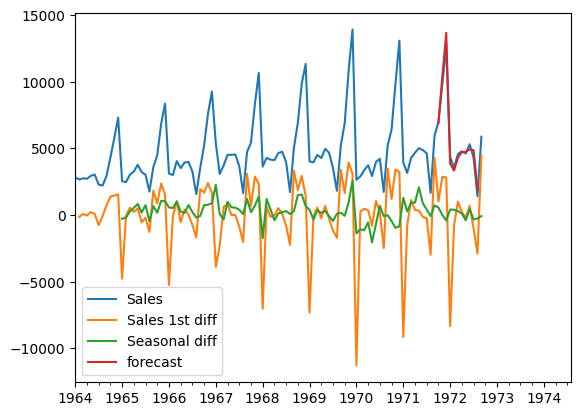

In [113]:
future_df.plot()

<AxesSubplot: >

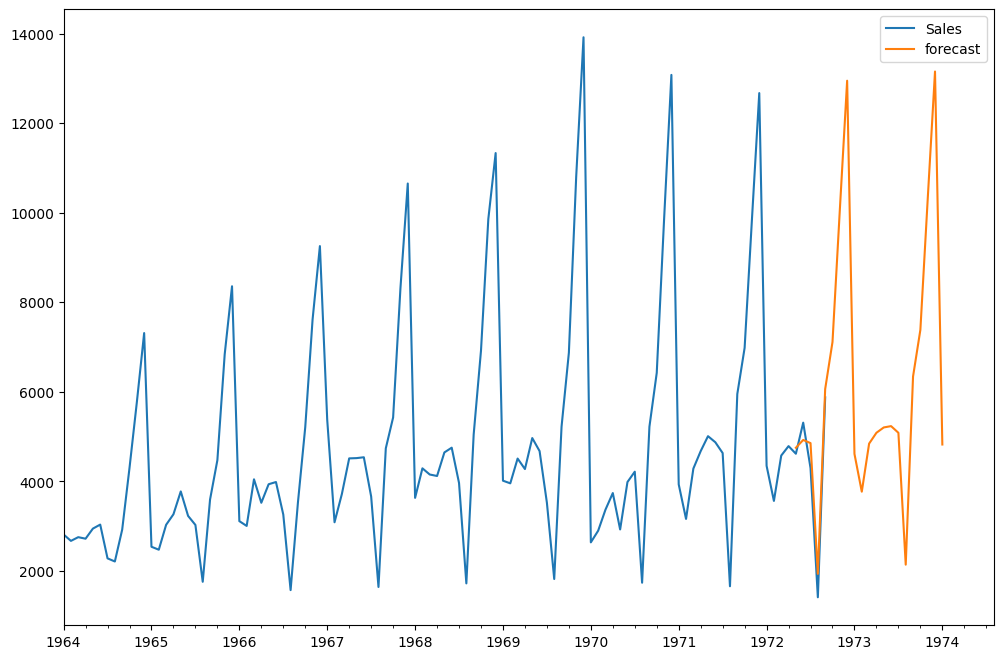

In [116]:
#now doing the future predictions
future_df['forecast'] = results.predict(start = 100, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 

In [115]:
df['forecast'].tail()

Months
1972-05-01    4739.963897
1972-06-01    4928.844779
1972-07-01    4862.576271
1972-08-01    1945.125568
1972-09-01            NaN
Name: forecast, dtype: float64